In [3]:
from lib import correlation
from os.path import join as opj
import nibabel as nib
import numpy as np
from nibabel.processing import resample_from_to
from nilearn import datasets, image, masking
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from os.path import join as opj

/local/egermani/miniconda3/envs/workEnv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [8]:
n_val = [20, 40, 60, 80,108]
teams = ['2T6S', 'V55J', 'Q6O0', 'C88N']
exp_dir = '/local/egermani/analytic_variability_fmri/data/derived/reproduced/NARPS-reproduction'

repro_unthresh= {}
repro_thresh = {}

for team_ID in teams:
    repro_unthresh.update({team_ID : {}})
    repro_thresh.update({team_ID : {}})
    for i, n in enumerate(n_val):
        if team_ID == '2T6S':
            repro_unthresh[team_ID].update({str(n) : opj(exp_dir, 
                                                         f"team_{team_ID}_nsub_{n}_hypo5_unthresholded.nii")})

            repro_thresh[team_ID].update({str(n) : opj(exp_dir,                                        
                                                       f"team_{team_ID}_nsub_{n}_hypo5_thresholded.nii")})
        else:
            repro_unthresh[team_ID].update({str(n) : opj(exp_dir, 
                                                         f"team_{team_ID}_nsub_{n}_hypo5_unthresholded.nii")})

            repro_thresh[team_ID].update({str(n) : opj(exp_dir,                                        
                                                       f"team_{team_ID}_nsub_{n}_hypo5_thresholded.nii")})

In [10]:
def get_stat_value_from_roi(atlas, lab, thresh_map):
    mask = masking.compute_brain_mask(image.index_img(atlas.maps, lab))
    img = nib.load(thresh_map)
    mask_resampled = resample_from_to(mask, img, order=0)
    
    masked_data = masking.apply_mask(img, mask_resampled)
    
    mean_stat = np.mean(masked_data[masked_data > 0])
    
    if mean_stat is None or np.isnan(mean_stat):
        mean_stat = 0 
    
    max_stat = np.amax(masked_data)
    min_stat = np.amin(masked_data)
    
    return masked_data[masked_data > 0]

In [7]:
atlas_cort = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm')

#coords = plotting.find_probabilistic_atlas_cut_coords(atlas_cort.maps)

#vmPFC = (int(coords[24][0]), int(coords[24][1]), int(coords[24][2]))

In [11]:
masked_data = get_stat_value_from_roi(atlas_cort, 24, repro_thresh['Q6O0']['80'])

In [13]:
masked_data

array([5.74558 , 5.620116], dtype=float32)

In [39]:
def get_pairwise_correlation(teams, n, repro_unthresh):
    correlation_dict = {}

    for i in range(len(teams)):
        correlation_dict.update({f"{teams[i]}" : {}})
        for j in range(len(teams)):
            if i != j:
                correlation_dict[teams[i]].update({f"{teams[j]}" : 0})
                corr1 = correlation.get_corr_coeff(repro_unthresh[teams[i]][str(n)], 
                                                 repro_unthresh[teams[j]][str(n)], 
                                                  method = 'pearson', reslice_on_2 = True)
                corr2 = correlation.get_corr_coeff(repro_unthresh[teams[j]][str(n)], 
                                                 repro_unthresh[teams[i]][str(n)], 
                                                  method = 'pearson', reslice_on_2 = True)
                corr = (corr1 + corr2) / 2
                correlation_dict[teams[i]][teams[j]] = corr
            else:
                correlation_dict[teams[i]].update({f"{teams[j]}" : 1})

    return correlation_dict

In [46]:
correlation_dict = get_pairwise_correlation(teams, 60, repro_unthresh)

In [47]:
import nibabel as nib
from nibabel.processing import resample_from_to
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import scipy
import os
import warnings
from scipy import stats

def correlation_matrix(df, title):
    mask = np.tri(df.shape[0], k=0)
    mask = 1-mask
    dfmsk = np.ma.array(df[:,:], mask=mask)
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('Reds')
    cmap.set_bad('w')
    cax = ax1.imshow(dfmsk, interpolation="nearest", cmap=cmap, vmin=0, vmax=1)
    
    for (i, j), z in np.ndenumerate(df):
        if (j < i):
             ax1.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='white', 
             edgecolor='0.3'))
     
    plt.title('test', fontsize=15)
    labels=['', '2T6S', '', 'V55J', '', 'Q6O0', '','C88N']        
        
    ax1.set_xticklabels(labels,fontsize=12)
    ax1.set_yticklabels(labels,fontsize=12)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[0,0.2,0.4,0.6,0.8,1], fraction=0.046, pad=0.04)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('none')
    ax1.xaxis.set_ticks_position('none')
    
    
def correlation_tables(correlation_dict, teams, num_subjects=None):    
    correlation_coefficients = np.zeros([4,4])
    
    for i, team_ID in enumerate(teams):
        correlation_coefficients[:, i] = [
            val for val in list(correlation_dict[team_ID].values())
        ]

    correlation_matrix(correlation_coefficients, 'test')

/tmp/ipykernel_1650/2382931330.py:19: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_bad('w')
/tmp/ipykernel_1650/2382931330.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels,fontsize=12)
/tmp/ipykernel_1650/2382931330.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels,fontsize=12)


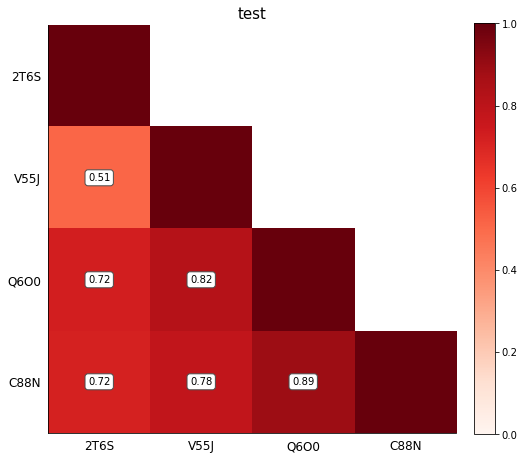

In [48]:
correlation_tables(correlation_dict, teams, num_subjects=None)

In [21]:
correlation_dict

{'2T6S': {'2T6S': 1,
  'V55J': 0.5135538961317248,
  'Q6O0': 0.6794664517052964,
  'C88N': 0.7003212332924986},
 'V55J': {'2T6S': 0.5135538961317248,
  'V55J': 1,
  'Q6O0': 0.8791568546698454,
  'C88N': 0.8542513355532655},
 'Q6O0': {'2T6S': 0.6794664517052964,
  'V55J': 0.8791568546698454,
  'Q6O0': 1,
  'C88N': 0.9259975876251284},
 'C88N': {'2T6S': 0.7003212332924986,
  'V55J': 0.8542513355532655,
  'Q6O0': 0.9259975876251284,
  'C88N': 1}}

In [30]:
def dice_matrix(df, title):
    mask = np.tri(df.shape[0], k=0)
    mask = 1-mask
    dfmsk = np.ma.array(df[:,:], mask=mask)
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('Reds')
    cmap.set_bad('w')
    cax = ax1.imshow(dfmsk, interpolation="nearest", cmap=cmap, vmin=0, vmax=1)
    
    for (i, j), z in np.ndenumerate(df):
        if (j < i):
             ax1.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='white', 
             edgecolor='0.3'))
     
    plt.title('test', fontsize=15)
    labels=['', '2T6S', '', 'V55J', '', 'Q6O0', '','C88N']        
        
    ax1.set_xticklabels(labels,fontsize=12)
    ax1.set_yticklabels(labels,fontsize=12)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[0,0.2,0.4,0.6,0.8,1], fraction=0.046, pad=0.04)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('none')
    ax1.xaxis.set_ticks_position('none')
    
    
def dice_tables(dice_dict, teams, num_subjects=None):    
    dice_coefficients = np.zeros([4,4])
    
    for i, team_ID in enumerate(teams):
        dice_coefficients[:, i] = [
            val for val in list(dice_dict[team_ID].values())
        ]

    dice_matrix(dice_coefficients, 'test')

In [43]:
from lib import dice

def get_pairwise_dice(teams, repro_thresh, n):
    dice_dict = {}

    for i in range(len(teams)):
        dice_dict.update({f"{teams[i]}" : {}})
        for j in range(len(teams)):
            if i != j:
                dice_dict[teams[i]].update({f"{teams[j]}" : 0})
                dice_val = dice.get_dice(repro_thresh[teams[i]][str(n)], repro_thresh[teams[j]][str(n)])
                dice_dict[teams[i]][teams[j]] = dice_val
            else:
                dice_dict[teams[i]].update({f"{teams[j]}" : 1})

    return dice_dict

In [44]:
dice_dict = get_pairwise_dice(teams, repro_thresh, 108)

/tmp/ipykernel_1650/1228955678.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_bad('w')
/tmp/ipykernel_1650/1228955678.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels,fontsize=12)
/tmp/ipykernel_1650/1228955678.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels,fontsize=12)


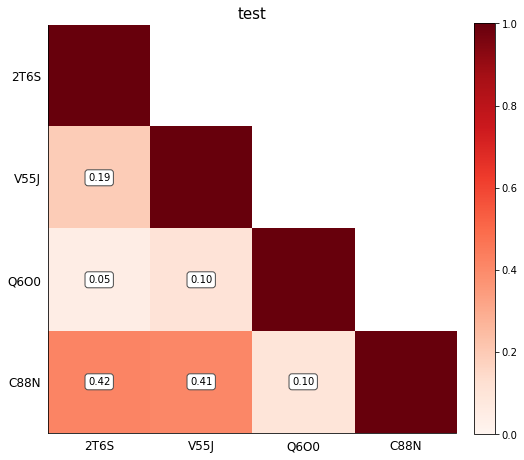

In [45]:
dice_tables(dice_dict, teams, num_subjects=None)